In [5]:
from pyqode.solver import Solver
import numpy as np
from pyqode.nozzle_2d import nasa_cdv_nozzle_verification_geometry
from pyqode.utils import r_to_k, psi_to_pa, meter_to_inch, area_to_radius, inch_to_meter, ft_to_meter, pa_to_psi, radius_to_area
import matplotlib.pyplot as plt
from pyqode.solver import PostProcessor, gen_su2_setup, gen_multizone_su2_setup
from pathlib import Path
import numpy as np
import pandas as pd
from pyqode.nozzle_2d import gen_nozzle_mesh, gen_wall_mesh, gen_multizone_mesh
from pyqode.solver import SU2Solver
import pyvista as pv

def run_1D(config):
    eq1d = Solver(config = config, executable='/home/ppiper/Dropbox/local/github/pyqode/pyqode/src/eulerQ1D')
    eq1d.run()

    # nozzle geometry
    plt.figure()
    plt.axis('equal')
    plt.plot( config['domain_x'], area_to_radius(config['domain_area']), color='k')
    plt.plot( config['domain_x'], -area_to_radius(config['domain_area']), color='k')
    plt.show()

    # post processor 
    pp = PostProcessor(f"{config['working_dir']}/outputs")

    # pressure
    #plt.plot(pp.x,pp.p)

    # mach
    #plt.plot(meter_to_inch(pp.x),pp.M)

    # residues
    plt.figure()
    plt.plot(pp.rese)
    plt.plot(pp.resrho)
    plt.plot(pp.resrhou)

    plt.yscale('log')
    plt.show()


# mesh coarse
#Nx = 50
#Ny = 20
#inflation_rate = 1.2
# CFL = 0.01

# mesh coarse
#Nx = 100
#Ny = 40
#inflation_rate = 1.1
# CFL = 0.01

# yplu2 
#Nx=60,
#        Ny=20,
#       inflation_rate=1.6,


def run_2D(config):
    config_su2 = config

    nozzle_mesh_file = gen_nozzle_mesh(
        xn=config['domain_x'],
        rn=area_to_radius(config['domain_area']),
        Nx=80,
        Ny=50,
        inflation_rate=1.2,
        output_file=  config['domain_mesh'],
        gmshsolver='/home/ppiper/Dropbox/local/github/pyqode/pyqode/src/gmsh',
        symmetry= True if config['domain_axisymmetric'] == 'YES' else False,
        using='Progression'
    )
    
    nozzle_mesh_file = Path(nozzle_mesh_file).with_suffix('.su2')

    fluid_cfg = gen_su2_setup(
        template='./template_fluid_su2_symmetry.cfg',
        config=config_su2,
        output_file= Path('./2D/fluid.cfg').resolve()
    )

    su2 = SU2Solver(
    config_file = fluid_cfg, 
    executable = '/home/ppiper/Dropbox/local/github/pyqode/pyqode/src/SU2-v8.0.0-linux64/bin/SU2_CFD',
    )
    
    su2.run()



def plot_validation(config_1D, config_2D, P0IN_PSI):

    data_valid= pd.read_csv('/home/ppiper/Dropbox/local/github/pyqode/examples/back/data/wpd_datasets.csv', delimiter=',', header=0)
    
    pp = PostProcessor(f"{config_1D['working_dir']}/outputs")

    vtu = pv.read('./2D/flow.vtm')
    vtu[0]['Boundary']['UPPER_WALL']

    p = pv.Plotter()
    p.add_mesh(vtu, scalars='Pressure')
    p.show(cpos='xy')
    
    #center = pd.DataFrame({'x':vtu[0]['Boundary']['SYMMETRY'].points[:,0], 
    #              'pressure':vtu[0]['Boundary']['SYMMETRY']['Pressure']})
    #center.sort_values(by=['x'], inplace=True)

    upper = pd.DataFrame({'x':vtu[0]['Boundary']['UPPER_WALL'].points[:,0],
                    'pressure':vtu[0]['Boundary']['UPPER_WALL']['Pressure']})
    upper.sort_values(by=['x'], inplace=True)
    
    plt.figure()
    #p0_in_psi = pa_to_psi(config['bc_p0'])
    plt.plot(pp.x,pp.p/psi_to_pa(P0IN_PSI), label='1D')
    plt.plot(upper['x'], upper['pressure'], label='2D-wall')
    plt.scatter(inch_to_meter(data_valid[f'X_{P0IN_PSI:.1f}']), data_valid[f'Y_{P0IN_PSI:.1f}'], label='validation')
    plt.legend()
    plt.xlabel('x [m]')
    plt.ylabel('p/p0')
    plt.title(f'Validation at p0={P0IN_PSI:.1f} psi')
    plt.savefig(f'pressure_validation_{P0IN_PSI:.1f}.png', dpi=300, bbox_inches='tight')
    plt.show()
    


In [6]:
data = pd.read_csv('/home/ppiper/Dropbox/local/github/pyqode/examples/back/data/geometry.asc', skiprows=1, delimiter=' ', header=None)
data.sort_values(by=[0], inplace=True)
xn_in = data.values[:, 0]
rn_in = data.values[:, 1]
xn = xn_in/1000
rn = rn_in/1000
sn = radius_to_area(rn)


P0IN_PSI_LIST = [45.1, 60.1, 75.0, 100.6, 150.4, 199.6, 250.2]
T0IN = r_to_k(1500)
PB = 101.325e3
GAMMA = 1.35
R = 287.0
AXISYMMETRIC = 'YES'
    

################################################################################
                           -*- Q1D Euler Solver -*-
Eigen 3.3.7
Allan Moreira de Carvalho
################################################################################
                           -*- Setup Information -*-
################################################################################
# Domain x-coordinates at cell faces (no need for ghost cells)
/home/ppiper/Dropbox/local/github/pyqode/examples/back/1D/inputs/xn.txt
# Area distributuin at cell faces (no need for ghost cells)
/home/ppiper/Dropbox/local/github/pyqode/examples/back/1D/inputs/sn.txt
# Inlet Total Pressure [Pa]
693612.856
# Inlet Total Temperature [K]
833.3333333333333
# Inlet Mach Number
0.0001
# Outlet Static Pressure [Pa]
101325.0
# Gas constant [J/kg/K]
287.0
# Specific heat ratio
1.35
# Maximum number of iterations 
50000
# Interval to print iterations 
1
# CFL number 
0.5
# Convergence criteria 
1e-15
# Time integratio

2401		9.06198e-06	1.14181e-05	3.70403e-05
2402		9.24206e-06	1.12986e-05	3.77344e-05
2403		9.41988e-06	1.11773e-05	3.84219e-05
2404		9.59596e-06	1.10541e-05	3.91003e-05
2405		9.77105e-06	1.09291e-05	3.97693e-05
2406		9.94381e-06	1.0962e-05	4.0429e-05
2407		1.01142e-05	1.10723e-05	4.10791e-05
2408		1.02822e-05	1.11822e-05	4.17197e-05
2409		1.04478e-05	1.12898e-05	4.23506e-05
2410		1.06109e-05	1.13949e-05	4.29717e-05
2411		1.07716e-05	1.14977e-05	4.3583e-05
2412		1.09298e-05	1.15979e-05	4.41843e-05
2413		1.10855e-05	1.16958e-05	4.47756e-05
2414		1.12387e-05	1.17912e-05	4.53567e-05
2415		1.13893e-05	1.18925e-05	4.5932e-05
2416		1.15374e-05	1.19926e-05	4.64987e-05
2417		1.16836e-05	1.20902e-05	4.7055e-05
2418		1.18281e-05	1.21853e-05	4.76009e-05
2419		1.19699e-05	1.22778e-05	4.81362e-05
2420		1.21091e-05	1.23678e-05	4.8661e-05
2421		1.22456e-05	1.24551e-05	4.91751e-05
2422		1.23794e-05	1.254e-05	4.96785e-05
2423		1.25105e-05	1.26222e-05	5.0171e-05
2424		1.26389e-05	1.27098e-05	5.06527e-05
2

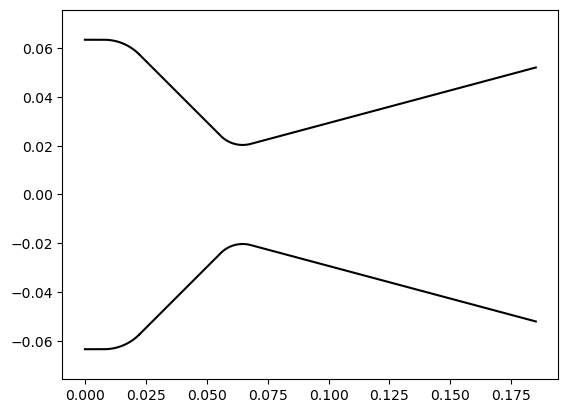

x
rese
u
p
resrhou
rho
S
e
T
M
resrho
c


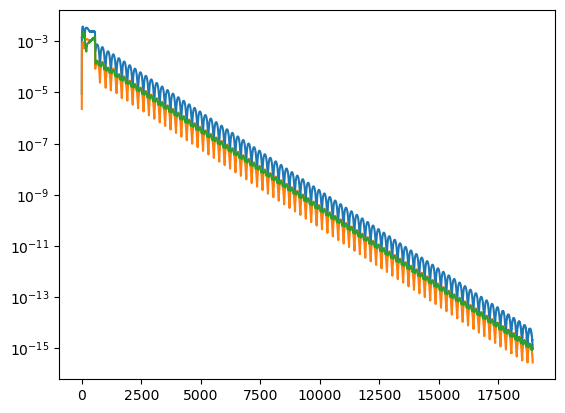

Info    : Running '/home/ppiper/Dropbox/local/github/pyqode/pyqode/src/gmsh /home/ppiper/Dropbox/local/github/pyqode/examples/back/2D/mesh/nozzle.geo -0 -2 -format su2 -o /home/ppiper/Dropbox/local/github/pyqode/examples/back/2D/mesh/nozzle.su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Sep 27 18:57:08 2023
Info    : Reading '/home/ppiper/Dropbox/local/github/pyqode/examples/back/2D/mesh/nozzle.geo'...
Info    : Done reading '/home/ppiper/Dropbox/local/github/pyqode/examples/back/2D/mesh/nozzle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.0133384s, CPU 0.031213s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00144997s, CPU 0.003713s)
Info    : 4834 nodes 4965 elements
Info    : Writing '/home/ppiper/Dropbox/local/github/pyqode/examples/bac

/home/ppiper/micromamba/envs/pyqode/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


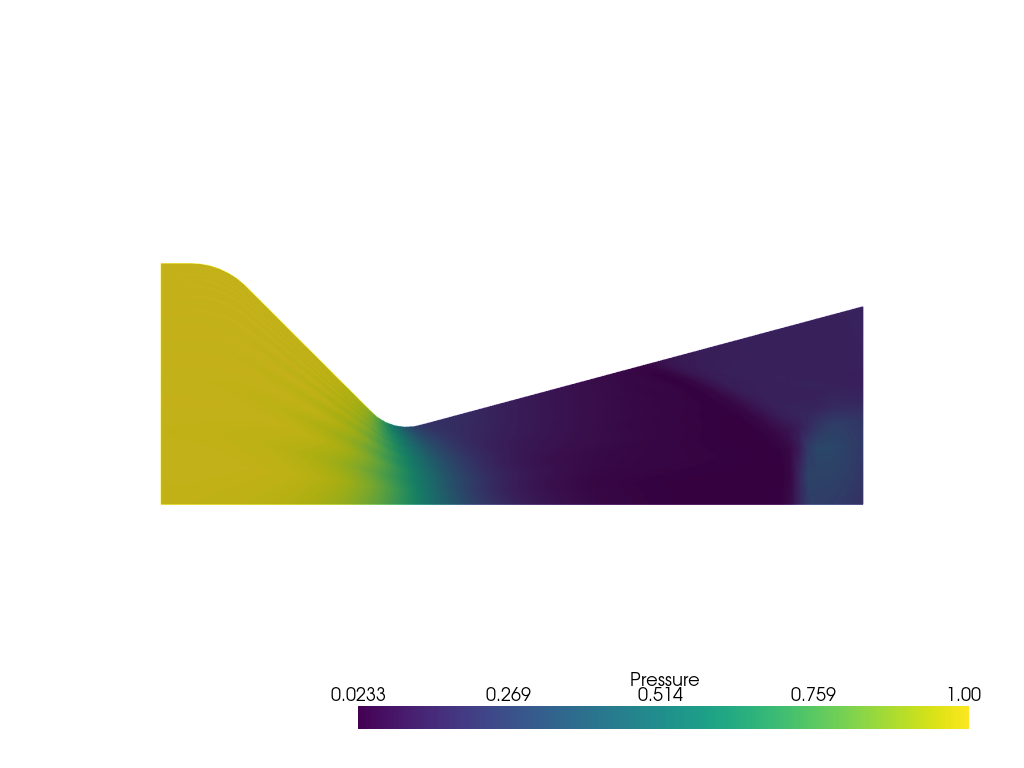

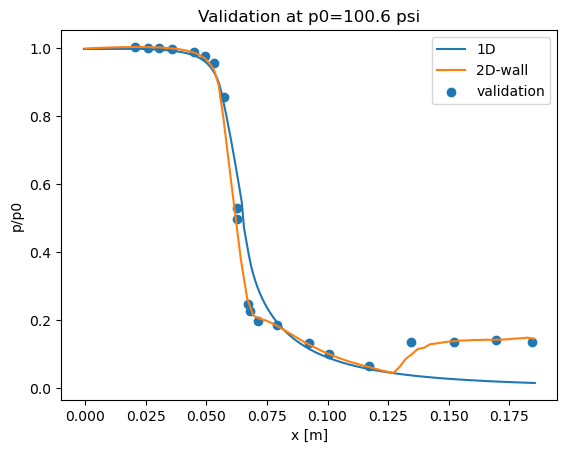

In [7]:
for P0IN_PSI in P0IN_PSI_LIST[3:4]:
    P0IN = psi_to_pa(P0IN_PSI)

    config_1D = {
        'working_dir': './1D',
        'domain_x': xn,
        'domain_area': sn,
        'domain_size': 200,
        'bc_p0': P0IN,
        'bc_T0': T0IN ,
        'bc_M': 0.0001,
        'bc_pb': PB,
        'fluid_R': R,
        'fluid_gamma': GAMMA,
        'solver_itmax': 50000,
        'solver_itprint': 1,
        'solver_CFL': 0.5,
        'solver_tol': 1e-15,
        'solver_tscheme': 'Euler',
        'solver_fscheme': 'AUSM',
        'solver_dttype': 'Global',
        'solver_dim': 'Dimensionless',  
    }

    config_2D = {
        'domain_x': xn,
        'domain_area': sn,
        'turbulence_model': 'SST',
        'solver_dim': 'FREESTREAM_PRESS_EQ_ONE',
        'fluid': 'IDEAL_GAS',
        'fluid_gamma': GAMMA,
        'fluid_R': R,
        'fluid_critical_temperature': 131.00,
        'fluid_critical_pressure': 3588550.0,
        'fluid_accentric_factor': 0.035,
        'fluid_viscosity_model': 'SUTHERLAND', 
        'fluid_sutherland_viscosity': 1.716E-5,
        'fluid_sutherland_temperature': 273.15,
        'fluid_sutherland_constant': 110.4,
        'fluid_conductivity_model': 'CONSTANT_PRANDTL',
        'fluid_laminar_prandtl': 0.72,
        'fluid_turbulent_prandtl': 0.9,
        'solver_CFL': 0.01,
        'domain_mesh': '/home/ppiper/Dropbox/local/github/pyqode/examples/back/2D/mesh/nozzle.su2',
        'domain_axisymmetric': AXISYMMETRIC,
        'bc_p0': P0IN,
        'bc_T0': T0IN,
        'bc_M': 0.000001,
        'bc_pb': PB,
        #'bc_Te': 0,
        'solver_itmax': 6000,
        'solver_tol': np.log10(1e-8),
        'solver_tscheme': 'EULER_IMPLICIT',
        'solver_fscheme': 'JST_KE',
        'solver_dttype': 'Global',
        'output_files': 'PARAVIEW',
        #'solid_density': 1000,
        #'multizone_mesh': Path(f'{config["working_dir"]}/2d_mesh/multizone.su2').resolve(),
        #'working_dir': './2D',
    }

    run_1D(config_1D)
    run_2D(config_2D)

    # validation plot
    plot_validation(config_1D, config_2D, P0IN_PSI)

In [8]:
vtu = pv.read('./2D/flow.vtm')
np.max(vtu[0]['Boundary']['UPPER_WALL']['Y_Plus'])

0.79723966